In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

%matplotlib inline

# DATA ANALYSIS

---

In [5]:
df = pd.read_csv('tweets.csv')
df.head(2)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   

  airline_sentiment_gold      name negativereason_gold  retweet_count  \
0                    NaN   cairdin                 NaN              0   
1                    NaN  jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)

In [6]:
df = df[['airline_sentiment', 'airline', 'retweet_count', 'text']]
df.head(2)

airline_sentiment         airline  retweet_count  \
0           neutral  Virgin America              0   
1          positive  Virgin America              0   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...

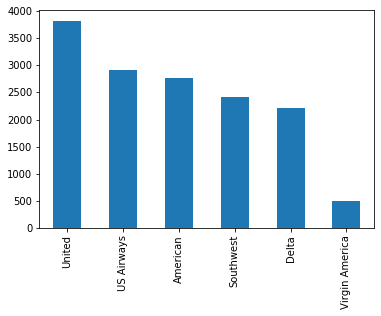

In [7]:
# make a bar plot of airlines vs tweet count
df.airline.value_counts().plot.bar();

In [8]:
# what is the probability of someone tweeting about United
print("{:.2f}%".format(((df.airline == 'United').sum() / df.shape[0]) * 100))

26.11%


In [9]:
# print out top 10 of the most retweeted tweets
for t in df.iloc[df.retweet_count.sort_values(ascending=False)[:10].index.tolist()].text:
    print("{}\n".format(t))

@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks)

@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time

STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY. RT @JetBlue: Our fleet's on fleek. http://t.co/Fd2TNYcTrB

@USAirways with this livery back in the day. http://t.co/EEqWVAMmiy

@SouthwestAir beautiful day in Seattle! http://t.co/iqu0PPVq2S

can you not? RT @JetBlue Our fleet's on fleek. http://t.co/413GiAL0yl

Just in case you needed confirmation that "on fleek" is dead &amp; gone. RT @JetBlue: Our fleet's on fleek. http://t.co/G4O6yX7TMJ

X____x RT @JetBlue: Our fleet's on fleek. http://t.co/Y39YzDpBvU

@JetBlue what a great experience on flight from SFO to JFK; seats, service, food, everything is top quality. I will be back. Very soon!

@USAirways Wow unbelievable how you treat your customers at Puerto Rico 

In [10]:
# which airline had the least amount of negative tweets
df.groupby(['airline_sentiment', 'airline']).agg(['count']).loc['negative', ('text', 'count')].sort_values().index[0]

'Virgin America'

# EDA

---

In [11]:
y = df.airline_sentiment.map({'negative':0, 'neutral':1, 'positive':2}).values
X = df.text.values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [13]:
snowball = SnowballStemmer('english')
from string import punctuation
sw = set(stopwords.words('english'))

def tokenize(doc):
    return [snowball.stem(word) for word in word_tokenize(doc.lower()) if word not in sw and word not in punctuation]

In [14]:
cv = CountVectorizer(strip_accents='ascii', lowercase=True, tokenizer=tokenize, analyzer='word', ngram_range=(1,2), max_features=25_000)
cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

In [15]:
cv.get_feature_names()[5010:5015]

['finnair', 'fire', 'first', 'first 4', 'first airlin']

In [16]:
tf = TfidfVectorizer(strip_accents='ascii', lowercase=True, tokenizer=tokenize, analyzer='word', ngram_range=(1,2), max_features=25_000)
tf_train = tf.fit_transform(X_train)
tf_test = tf.transform(X_test)

In [17]:
tf.get_feature_names()[5010:5015]

['finnair', 'fire', 'first', 'first 4', 'first airlin']

# CHOOSE BEST NLP TOOL

---

In [18]:
# count vectorizer
RandomForestClassifier(n_estimators=100).fit(cv_train, y_train).score(cv_test, y_test)

0.7684426229508197

In [19]:
# tfidf vectorizer
RandomForestClassifier(n_estimators=100).fit(tf_train, y_train).score(tf_test, y_test)

0.7657103825136612

- They are basically the same, but I will choose **TFIDF**

# MODEL BUILDING

---

In [20]:
# baseline accuracy 62.7%
df.airline_sentiment.value_counts() / df.shape[0]

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [21]:
# random forest classifier
rfc_params = {'criterion': ['gini', 'entropy']}
rfc = GridSearchCV(RandomForestClassifier(n_estimators=100), rfc_params, n_jobs=-1, verbose=1, scoring='accuracy', cv=5).fit(tf_train, y_train)
rfc.best_params_, rfc.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.0s finished


({'criterion': 'entropy'}, 0.755464480874317)

In [22]:
# gradient boosted classifier
gbc_params = {'learning_rate': [0.1, 0.5, 0.99]}
gbc= GridSearchCV(GradientBoostingClassifier(n_estimators=100), gbc_params, n_jobs=-1, verbose=1, scoring='accuracy', cv=5).fit(tf_train, y_train)
gbc.best_params_, gbc.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


({'learning_rate': 0.5}, 0.7461943793911007)

In [23]:
# logistic regression
lr_params = {'C': [0.1, 0.5, 0.99]}
lr= GridSearchCV(LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000), lr_params, n_jobs=-1, verbose=1, scoring='accuracy', cv=5).fit(tf_train, y_train)
lr.best_params_, lr.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.1s finished


({'C': 0.99}, 0.7690281030444965)

In [24]:
# knn
knn_params = {'n_neighbors':[3, 9, 15, 21, 49], 'weights': ['uniform', 'distance']}
knn= GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, verbose=1, scoring='accuracy', cv=5).fit(tf_train, y_train)
knn.best_params_, knn.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.3s finished


({'n_neighbors': 21, 'weights': 'distance'}, 0.7421935987509758)

In [25]:
# svc
svc_params = {'C': [0.1, .5, 2], 'kernel': ['linear', 'poly', 'rbf']}
svc= GridSearchCV(SVC(gamma='auto'), svc_params, n_jobs=-1, verbose=1, scoring='accuracy', cv=5).fit(tf_train, y_train)
svc.best_params_, svc.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/chyld/.local/miniconda3/envs/py37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


({'C': 2, 'kernel': 'linear'}, 0.7745901639344263)

In [26]:
# neural network
model = Sequential([
    Dense(1024, activation='relu', input_shape=(25_000,)),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25601024  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 25,732,611
Trainable params: 25,732,611
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(tf_train.todense(), y_train, epochs=10, validation_split=0.3, shuffle=True, batch_size=32, verbose=1)

Train on 7173 samples, validate on 3075 samples
Epoch 1/10
7173/7173 [==============================] - 20s 3ms/sample - loss: 0.6564 - accuracy: 0.7222 - val_loss: 0.5532 - val_accuracy: 0.7798
Epoch 2/10
7173/7173 [==============================] - 20s 3ms/sample - loss: 0.1770 - accuracy: 0.9349 - val_loss: 0.6972 - val_accuracy: 0.7642
Epoch 3/10
7173/7173 [==============================] - 20s 3ms/sample - loss: 0.0407 - accuracy: 0.9879 - val_loss: 0.9077 - val_accuracy: 0.7616
Epoch 4/10
7173/7173 [==============================] - 22s 3ms/sample - loss: 0.0214 - accuracy: 0.9922 - val_loss: 1.0012 - val_accuracy: 0.7584
Epoch 5/10
7173/7173 [==============================] - 22s 3ms/sample - loss: 0.0171 - accuracy: 0.9939 - val_loss: 1.0688 - val_accuracy: 0.7633
Epoch 6/10
7173/7173 [==============================] - 20s 3ms/sample - loss: 0.0135 - accuracy: 0.9950 - val_loss: 1.1126 - val_accuracy: 0.7593
Epoch 7/10
7173/7173 [==============================] - 20s 3ms/sample

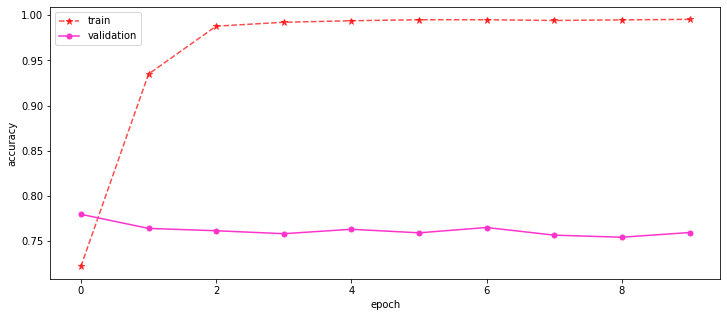

In [79]:
plt.figure(figsize=(12,5))
plt.plot(history.epoch, history.history['accuracy'], label='train', linestyle='--', color='red', alpha=0.7, marker='*', markersize=7)
plt.plot(history.epoch, history.history['val_accuracy'], label='validation', linestyle='-', color='#ff33cc', marker='.', markersize=10)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy');

# CHOOSE FINAL MODEL

---

In [30]:
final = SVC(**svc.best_params_).fit(tf_train, y_train)

# EVALUATE FINAL MODEL

In [31]:
y_hat = final.predict(tf_test)
y_hat[:3]

array([2, 0, 0])

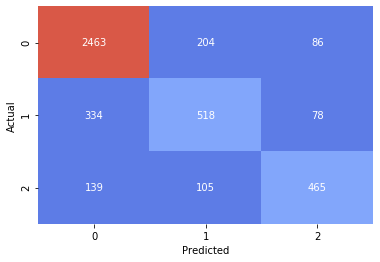

In [77]:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# *husl* is a color palette, *8* is how many shades of that palette we want
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cbar=False, fmt='d', cmap=sns.color_palette('coolwarm', 8))
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [33]:
final.score(tf_test, y_test)

0.7846083788706739

In [34]:
# went from 62% accuracy to 78% accuracy